# 19. Natural experiments revisited --- Part2
2024/4/30 李子明、王梦涵、赵吕宇佳

分工情况：各自完成代码，一起讨论解决遇到的问题

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import linearmodels as lm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from regtabletotext import prettify_result, prettify_results
from sqlalchemy import create_engine
import psycopg2

# 19.5 The parallel trends assumption

上述的Reg SHO研究中，处理的随机性使得处理前的处理组与对照组结果得以平衡。平行趋势假设是指，如果处理没有发生，处理组的结果变量预期变化与对照组的结果变量预期变化相同。在这一假设下，我们可以将处理组与对照组结果变量的变化之间的差异归因于处理效应。

检验平行趋势假设有两种方法，一种是比较处理组和对照组的在处理前结果的趋势。 如果这些趋势在处理前相似，则可以合理地假设它们在处理后也相似。另一种是placebo测试，涉及预先认为应该没有效果的情况下评估处理效果，或者随机实施伪处理。

下面，我们将进行一项伪处理研究，我们假设该处理发生于2004年第一季度开始，大约是样本期的一半。

In [ ]:
con = psycopg2.connect(dbname='wrds', 
                        user='******', 
                        password = '******',
                        host='wrds-pgdata.wharton.upenn.edu', 
                        port=9737)

wrds = create_engine('postgresql+psycopg2://', creator=lambda: con)

In [ ]:
dsf = pd.read_sql_query(
  sql=" SELECT date, permno, ask, bid FROM crsp.dsf WHERE date >= '2000-01-01' AND date <= '2008-12-31'",
  con=wrds,
  dtype={"permno": str},
  parse_dates={'date'}
)

dsf['date'] = pd.to_datetime(dsf['date'])
dsf['spread'] = 100 * (dsf['ask'] - dsf['bid']) / ((dsf['ask'] + dsf['bid']) / 2) # 计算买卖价差
dsf['quarter'] = dsf['date'].dt.to_period('Q')  # 确定季度

spreads = (dsf.groupby(['permno', 'quarter'])
           .agg(spread_mean=('spread', 'mean')) # 计算季度平均spread
           .reset_index()
)

spreads['post'] = spreads['quarter'].astype(str) >= '2004Q1' # 添加post标记, 2004年第一季度前post=0,之后post=1
start_date = pd.Period('2000Q1')
end_date = pd.Period('2008Q1')
spreads = spreads[(spreads['spread_mean'].notna()) & (spreads['quarter'].between(start_date, end_date))]

In [2]:
spreads

,permno,quarter,spread,post
0,10001,2000-01-01,2.813493,False
1,10001,2000-04-01,3.398916,False
2,10001,2000-07-01,2.340752,False
3,10001,2000-10-01,3.249916,False
4,10001,2001-01-01,3.299582,False
...,...,...,...,...
240189,93105,2007-04-01,0.376705,True
240190,93105,2007-07-01,0.772961,True
240191,93105,2007-10-01,0.893968,True
240192,93105,2008-01-01,1.179510,True


我们现在随机分配处理组和对照组，因为我们想评估平行趋势假设，如果完全随机地指定处理组和对照组将使得处理前完全没有差异，这是平行趋势假设测试的简单版本，所以我们为处理前买卖价差平均值超过中位数的观测设置接受处理的概率为0.55，而处理前买卖价差平均值小于中位数的观测为0.45，这保证了处理前的处理组买卖价差平均而言会大于对照组的买卖价差。

In [3]:
# 由于python和R随机数生成的算法不同,因此使用相同的随机种子生成的随机数不一样,这里我们在R中生成0至1的随机数，并将结果储存为CSV文件
randomseed_2021 = pd.read_csv("randomseed_2021.csv")

In [4]:
treatment = (spreads
             .query("post == False")
             .groupby("permno")
             .agg(spread_mean=("spread", "mean"))
             .reset_index()
             .merge(randomseed_2021, on = ["permno"], how = 'left')
)
# 根据中位数分配处理概率,如果spread均值大于中位数,treat_prob为0.55,否则为0.45
treatment["treat_prob"] = np.where(treatment["spread_mean"] > np.median(treatment["spread_mean"]), 0.55, 0.45)
# 基于随机数和处理概率,决定是否接受处理
treatment["treat"] = treatment["rand"] < treatment["treat_prob"]
treatment = treatment[["permno", "treat"]]
treatment

,permno,treat
0,10001,True
1,10002,False
2,10009,False
3,10012,True
4,10016,False
...,...,...
10078,92866,True
10079,92874,False
10080,92930,False
10081,93105,False


In [5]:
# 连接买卖价差数据,计算交乘项
reg_data = spreads.merge(treatment, on=["permno"], how='inner')
reg_data["postXtreat"] = reg_data["post"] * reg_data["treat"]
reg_data

,permno,quarter,spread,post,treat,postXtreat
0,10001,2000-01-01,2.813493,False,True,False
1,10001,2000-04-01,3.398916,False,True,False
2,10001,2000-07-01,2.340752,False,True,False
3,10001,2000-10-01,3.249916,False,True,False
4,10001,2001-01-01,3.299582,False,True,False
...,...,...,...,...,...,...
220817,93105,2007-04-01,0.376705,True,False,False
220818,93105,2007-07-01,0.772961,True,False,False
220819,93105,2007-10-01,0.893968,True,False,False
220820,93105,2008-01-01,1.179510,True,False,False


In [6]:
# 回归
reg_model = smf.ols("spread ~ post + treat + postXtreat", data=reg_data).fit()
reg_model_with_cluster = reg_model.get_robustcov_results(cov_type='cluster', groups=reg_data['permno']) # 标准误在公司层面聚类
print(reg_model_with_cluster.summary())

                            OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     1497.
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:21:14   Log-Likelihood:            -6.0500e+05
No. Observations:              220822   AIC:                         1.210e+06
Df Residuals:                  220818   BIC:                         1.210e+06
Df Model:                           3                                         
Covariance Type:              cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8305      0

可以看到，交乘项-4.96的统计量在1%的水平上显著，但我们随机施加的处理没有任何实际意义。因此可以得出结论，平行趋势假设不适用于该样本中的分布。

# 19.6 Indirect effects of Reg SHO --- FHK

Reg SHO实验对试点公司产生了广泛的间接影响，包括盈余管理、投资、杠杆、收购、管理层薪酬、工作场所安全等。Fang，Huang，and Karpoff(2016)指出，卖空或其前景会抑制盈余管理。接下来我们将复现FHK(2016)的研究内容。

Kothari等(2005)认为可操纵性应计会受到公司绩效的影响，因此采用绩效配对法以控制公司绩效。具体的，将每个样本公司与来自同一年度和行业并且资产回报率最接近的公司进行配对，与绩效配对的可操纵性应计（performance-matched discretionary accruals）计算为公司特定的可操纵性应计减去配对公司的可操纵性应计。FHK(2016)采用了这种应计盈余管理的衡量方法，但FHK按行业和年份估计可操纵性应计模型，其中行业基于48个行业的Fama-French分组，而不是Kothari等(2005)使用的两位数SIC代码。

In [ ]:
compustat_annual = pd.read_sql_query(
  sql=f'''
        SELECT gvkey, fyear, datadate, fyr, sich, dltt, dlc, seq, oibdp, ib, ibc, oancf, xidoc, at, ppegt, sale, rect, ceq, csho, prcc_f
        FROM comp.funda
        WHERE indfmt = 'INDL'
        AND datafmt = 'STD'
        AND popsrc = 'D'
        AND consol = 'C'
        AND fyear BETWEEN 1999 AND 2012
        AND NOT (sich BETWEEN 6000 AND 6999 OR sich BETWEEN 4900 AND 4949)
        ''',
  con=wrds,
  dtype={"permno": str},
  parse_dates={'date'}
)

In [7]:
compustat_annual

,gvkey,fyear,datadate,fyr,sich,dltt,dlc,seq,oibdp,ib,ibc,oancf,xidoc,at,ppegt,sale,rect,ceq,csho,prcc_f
0,1004,1999,2000-05-31,5,5080,180.447,26.314,339.515,89.031,35.163,35.163,10.051,0.0,740.998,202.597,1024.333,128.348,339.515,26.865,13.875
1,1004,2000,2001-05-31,5,5080,179.987,13.652,340.212,64.367,18.531,18.531,46.093,0.0,701.854,202.385,874.255,115.187,340.212,26.937,14.000
2,1004,2001,2002-05-31,5,5080,217.699,42.525,310.235,27.207,-58.939,-58.939,-33.315,0.0,710.199,198.225,638.721,77.528,310.235,31.870,11.440
3,1004,2002,2003-05-31,5,5080,164.658,92.256,294.988,30.745,-12.410,-12.410,34.733,0.0,686.621,271.460,606.337,66.322,294.988,31.851,4.500
4,1004,2003,2004-05-31,5,5080,248.666,3.392,301.684,47.491,3.504,3.504,14.572,0.0,709.292,278.474,651.958,104.661,301.684,32.245,9.580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92009,287882,2011,2011-12-31,12,2911,4128.449,430.766,28328.827,15844.983,8004.309,8125.198,11912.089,0.0,47799.686,47027.828,34059.674,2401.362,28328.827,2055.835,44.520
92010,287882,2012,2012-12-31,12,2911,6536.011,1276.309,36902.302,16643.699,8424.000,8663.034,11702.802,0.0,64911.359,47051.377,39245.641,2999.056,36902.302,2055.835,59.670
92011,295786,2012,2012-12-31,12,3523,27052.000,0.000,3924.000,2834.000,756.000,876.000,842.000,0.0,48965.000,15832.000,31529.000,22033.000,3924.000,1222.560,NaN
92012,296697,2012,2012-12-31,12,4512,48.018,40.683,81.168,41.272,16.603,15.684,38.373,0.0,439.816,115.455,901.486,29.877,81.168,82.208,NaN


In [8]:
# 计算市账比mtob、资产负债率leverage和总资产回报率roa
controls_raw = (compustat_annual
                .sort_values(by=["gvkey", "fyear"])
                .groupby("gvkey")
                .apply(lambda x: x.assign(
                lag_fyear = x["fyear"].shift(1),
                mtob = (x["csho"].shift(1) * x["prcc_f"].shift(1) / x["ceq"].shift(1)).where(x["ceq"].shift(1) != 0, np.nan),
                leverage = ((x["dltt"] + x["dlc"]) / (x["dltt"] + x["dlc"] + x["seq"])).where(x["dltt"] + x["dlc"] + x["seq"] != 0, np.nan),
                roa = (x["oibdp"] / x["at"].shift(1)).where(x["at"].shift(1) > 0, np.nan)))
                .query("fyear == lag_fyear + 1")
                .reset_index(drop=True)
                .get(["gvkey", "datadate", "fyear", "at", "mtob", "leverage", "roa"])
)
# csho --- Common Shares Outstanding
# prcc_f --- Price Close (Annual,Fiscal)
# ceq --- Book Value of Equity
# dltt --- Long-term Debts
# dlc --- Debts in Current Liabilities
# seq --- Stockholders Equity (Total)
# oibdp --- Operating Income Before Depreciation
controls_raw

C:\Users\12410\AppData\Local\Temp\ipykernel_8904\60989562.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(


,gvkey,datadate,fyear,at,mtob,leverage,roa
0,1004,2001-05-31,2000,701.854,1.097895,0.362721,0.086865
1,1004,2002-05-31,2001,710.199,1.108479,0.456166,0.038764
2,1004,2003-05-31,2002,686.621,1.175215,0.465507,0.043291
3,1004,2004-05-31,2003,709.292,0.485882,0.455190,0.069166
4,1004,2005-05-31,2004,732.230,1.023943,0.423174,0.087092
...,...,...,...,...,...,...,...
78290,298636,2012-12-31,2012,4320.923,NaN,0.715062,0.101361
78291,306398,2012-12-31,2012,48.885,NaN,0.002988,-0.415570
78292,311524,2012-12-31,2012,1847.000,NaN,0.810754,0.123538
78293,316056,2012-12-31,2012,1983.800,NaN,0.003709,0.206217


In [9]:
# 填充控制变量的缺失值
controls_filled = (controls_raw
                   .sort_values(by=["gvkey", "fyear"])
                   .groupby("gvkey")
                   .apply(lambda x: x.sort_values("fyear").ffill())
                   .reset_index(drop=True)
)

C:\Users\12410\AppData\Local\Temp\ipykernel_8904\614910406.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values("fyear").ffill())


In [10]:
# 计算控制变量的每一年度平均值
controls_fyear_avg = (
    controls_filled
    .groupby("fyear")
    .agg({"at": "mean", "mtob": "mean", "leverage": "mean", "roa": "mean"})
    .rename(columns={'at': 'at_avg', 'mtob': 'mtob_avg', 'leverage': 'leverage_avg', 'roa': 'roa_avg'})
)
controls_fyear_avg

,at_avg,mtob_avg,leverage_avg,roa_avg
fyear,,,,
2000,1952.169122,3.783867,2.019920e-01,-2.011033
2001,2061.386057,6.110423,3.028094e-01,-2.528691
2002,2250.847984,-2.312231,3.243038e-01,-2.008179
2003,2538.277659,1.979321,1.166154e-01,-2.806138
2004,2834.236698,4.756113,2.047467e-01,-3.695235
2005,3025.725829,2.645579,8.036691e-02,-3.565512
2006,3398.361666,3.827481,2.523523e-01,-3.529762
2007,3997.724707,0.889992,1.348038e+12,-1.661424
2008,4143.641065,7.589980,2.743102e-01,-1.772138


In [11]:
# 以当年均值填补缺失值
df_controls = (
    controls_filled
    .merge(controls_fyear_avg, on="fyear", how="inner")
    .assign(
        at = lambda x: x["at"].combine_first(x["at_avg"]),
        mtob = lambda x: x["mtob"].combine_first(x["mtob_avg"]),
        leverage = lambda x: x["leverage"].combine_first(x["leverage_avg"]),
        roa = lambda x: x["roa"].combine_first(x["roa_avg"]))
    .filter(items=["gvkey", "fyear", "at", "mtob", "leverage", "roa"])
)
df_controls

,gvkey,fyear,at,mtob,leverage,roa
0,1004,2000,701.854,1.097895,0.362721,0.086865
1,1004,2001,710.199,1.108479,0.456166,0.038764
2,1004,2002,686.621,1.175215,0.465507,0.043291
3,1004,2003,709.292,0.485882,0.455190,0.069166
4,1004,2004,732.230,1.023943,0.423174,0.087092
...,...,...,...,...,...,...
78290,298636,2012,4320.923,-7.718387,0.715062,0.101361
78291,306398,2012,48.885,-7.718387,0.002988,-0.415570
78292,311524,2012,1847.000,-7.718387,0.810754,0.123538
78293,316056,2012,1983.800,-7.718387,0.003709,0.206217


In [12]:
# 48个行业的Fama-French分组在farr包中提供,这里我们直接导入
ff_ind_48 = pd.read_csv("ff_ind_48.csv")
ff_ind_48

,ff_ind,ff_ind_short_desc,ff_ind_desc,sic_min,sic_max,sic_desc
0,1,Agric,Agriculture,100,199,Agricultural production - crops
1,1,Agric,Agriculture,200,299,Agricultural production - livestock
2,1,Agric,Agriculture,700,799,Agricultural services
3,1,Agric,Agriculture,910,919,Commercial fishing
4,1,Agric,Agriculture,2048,2048,Prepared feeds for animals
...,...,...,...,...,...,...
593,47,Fin,Trading,6799,6799,"Investors, NEC"
594,48,Other,Almost Nothing,4950,4959,Sanitary services
595,48,Other,Almost Nothing,4960,4961,Steam & air conditioning supplies
596,48,Other,Almost Nothing,4970,4971,Irrigation systems


In [13]:
# 定义比较函数,遍历ff_ind_48,如果行业代码sich在某一行业类的sic_min和sic_max之间,则返回该行业类标签,否则返回None
def compare_values(row):
    for _, r in ff_ind_48.iterrows():
        if r['sic_min'] < row['sich'] < r['sic_max']: 
            return r['ff_ind']
    else:
        return None

compustat_annual['industry'] = compustat_annual.apply(compare_values, axis=1)
compustat_annual = compustat_annual.dropna(subset=['industry']) # 剔除无法匹配行业标签的行

我们采用经典的Jones模型，从营业收入变动和固定资产水平衡量企业应计利润的变动，具体模型如下：

$\frac{TA_{i,t-1}}{A_{i,t}}=\alpha_1\frac{1}{A_{i,t-1}}+\alpha_2\frac{\Delta REV_{i,t}}{A_{i,t-1}}+\alpha_2\frac{PPE_{i,t}}{A_{i,t-1}}+\epsilon_{i,t}$

这里的$TA_{i,t}$是应计项目总额；$\Delta REV_{i,t}$是营业收入增量，用来控制取决于收入的经营活动的非操纵性应计项目；$PPE_{i,t}$是固定资产总额，用来控制资产摊销部分的非操纵性应计项目。

In [14]:
# 计算回归变量
for_disc_accruals = (compustat_annual
                     .sort_values(by=['gvkey', 'fyr', 'fyear'])
                     .groupby(['gvkey', 'fyr'])
                     .apply(lambda x: x.assign(lag_at=x["at"].shift(1)))
                     .query("lag_at > 0")
)

for_disc_accruals["lag_fyear"] = for_disc_accruals["fyear"].shift(1)
for_disc_accruals["acc_at"] = (for_disc_accruals["ibc"] - (for_disc_accruals["oancf"] - for_disc_accruals["xidoc"])) / for_disc_accruals["lag_at"]
for_disc_accruals["one_at"] = 1 / for_disc_accruals["lag_at"]
for_disc_accruals["ppe_at"] = for_disc_accruals["ppegt"] / for_disc_accruals["lag_at"]
for_disc_accruals["sale_c_at"] = (for_disc_accruals["sale"] - for_disc_accruals["sale"].shift(1)) / for_disc_accruals["lag_at"]
for_disc_accruals["salerect_c_at"] = ((for_disc_accruals["sale"] - for_disc_accruals["sale"].shift(1)) - (for_disc_accruals["rect"] - for_disc_accruals["rect"].shift(1))) / for_disc_accruals["lag_at"]
# ibc --- Income Before Extraordinary Items(Cash Flow)
# oancf --- Operating Activities Net Cash Flow
# xidoc --- Extraordinary Items and Discontinued Operations(Cash Flow)
# rect --- Receivables Total

for_disc_accruals = for_disc_accruals.reset_index(drop=True)
for_disc_accruals['keep'] = np.abs(for_disc_accruals['acc_at']) <= 1

for_disc_accruals = for_disc_accruals[(for_disc_accruals['lag_fyear'] == for_disc_accruals['fyear'] - 1)
                                        & (for_disc_accruals['keep'])
                                        & (~for_disc_accruals['salerect_c_at'].isna())
                                        & (~for_disc_accruals['acc_at'].isna())
                                        & (~for_disc_accruals['ppe_at'].isna())]
for_disc_accruals['num_obs'] = for_disc_accruals.groupby(['industry', 'fyear'])['datadate'].transform('count')
for_disc_accruals = for_disc_accruals[for_disc_accruals['num_obs'] >= 10]

C:\Users\12410\AppData\Local\Temp\ipykernel_8904\2436586527.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(lag_at=x["at"].shift(1)))


用样本公司数据估计出回归模型参数后，操纵性应计计算为：

$NA_{i,t}=\frac{TA_{i,t}}{A_{i,t-1}}-\alpha_1\frac{1}{A_{i,t-1}}-\alpha_2\frac{\Delta REV_{i,t}}{A_{i,t-1}}-\alpha_2\frac{PPE_{i,t}}{A_{i,t-1}}$

In [15]:
results = []
for (industry, fyear), group in for_disc_accruals.groupby(['industry', 'fyear']):
    model = smf.ols('acc_at ~ one_at + sale_c_at + ppe_at', data = group).fit() # 利用对于每个行业和年度的样本数据进行回归
    model_params = model.params.reset_index()  # 获取模型参数
    model_params.columns = ['term', 'estimate']
    model_params['industry'] = industry
    model_params['fyear'] = fyear
    results.append(model_params)

fm_results = pd.concat(results)

fm_da = fm_results.pivot(index=['industry', 'fyear'], columns='term', values='estimate').reset_index()
fm_da.columns = ['industry', 'fyear', 'b_Intercept', 'b_one_at', 'b_sale_c_at', 'b_ppe_at']
fm_da

,industry,fyear,b_Intercept,b_one_at,b_sale_c_at,b_ppe_at
0,2.0,2001,-0.026624,0.376441,-0.062041,0.045378
1,2.0,2002,-0.030300,0.338666,-0.031896,-0.031503
2,2.0,2003,-0.044527,-0.652994,-0.032648,0.138717
3,2.0,2004,0.004415,-0.110568,-0.068177,-0.000819
4,2.0,2005,-0.045584,1.124077,-0.012320,0.045532
...,...,...,...,...,...,...
315,48.0,2008,-0.033529,-0.811112,-0.040321,0.285821
316,48.0,2009,0.016141,-1.399331,-0.090550,0.154413
317,48.0,2010,-0.034271,-1.313758,-0.047875,0.092728
318,48.0,2011,-0.014825,-1.611296,-0.075746,0.066562


In [16]:
das = for_disc_accruals.merge(fm_da, on=['industry', 'fyear'], how='left')

das['nda'] = (das['b_Intercept']
             + das['one_at'] * das['b_one_at']
             + das['ppe_at'] * das['b_ppe_at']
             + das['salerect_c_at'] * das['b_sale_c_at']) # 计算非操纵性应计
# 这里为什么要用salerect_c_at(营收增量-应收账款增量)计算？

das['da'] = das['acc_at'] - das['nda'] # 计算操纵性应计

das = das[['gvkey', 'fyear', 'industry', 'acc_at', 'da']]

In [17]:
# 计算公司绩效
perf = (compustat_annual
        .sort_values(by=['gvkey', 'fyear'])
        .groupby('gvkey')
        .apply(lambda x: x.assign(ib_at = np.where(x['at'].shift(1) > 0, x['ib'].shift(1) / x['at'].shift(1),
                                                        np.where(x['at'] > 0, x['ib'] / x['at'], np.nan))))
        .reset_index(drop=True)
        .loc[:, ['gvkey', 'fyear', 'industry', 'ib_at']]
)
# ib --- Income Before Extraordinary Items

C:\Users\12410\AppData\Local\Temp\ipykernel_8904\226863638.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(ib_at = np.where(x['at'].shift(1) > 0, x['ib'].shift(1) / x['at'].shift(1),


In [18]:
# 根据公司绩效进行配对
perf_match = pd.merge(perf, perf, on=['fyear', 'industry'], suffixes=('', '_other')) # 根据年度和行业perf与自身合并
perf_match = perf_match[perf_match['gvkey'] != perf_match['gvkey_other']]
perf_match['perf_diff'] = np.abs(perf_match['ib_at'] - perf_match['ib_at_other']) # 计算ib_at的绝对差异
perf_match = (perf_match
              .groupby(['gvkey', 'fyear'])
              .apply(lambda x: x[x['perf_diff'] == x['perf_diff'].min()]) # 选取差异最小的行，代表了与当前gvkey最匹配的gvkey_other
              .reset_index(drop=True)
              .loc[:, ['gvkey', 'fyear', 'gvkey_other']]
)

C:\Users\12410\AppData\Local\Temp\ipykernel_8904\822660660.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[x['perf_diff'] == x['perf_diff'].min()]) # 选取差异最小的行，代表了与当前gvkey最匹配的gvkey_other


In [19]:
# 操纵性应计数据das根据配对的gvkey进行连接,计算与绩效配对的可操纵性应计
perf_matched_accruals =(das
                        .rename(columns={'gvkey': 'gvkey_other', 'da': 'da_other'})
                        .loc[:, ['fyear', 'gvkey_other', 'da_other']]
                        .merge(perf_match, on=['gvkey_other', 'fyear'], how='inner')
                        .loc[:, ['gvkey', 'fyear', 'gvkey_other', 'da_other']]
)
das = das.merge(perf_matched_accruals, on=['gvkey', 'fyear'], how='inner')
das["da_adj"] = das["da"] - das["da_other"] # 公司特定的可操纵性应计减去配对公司的可操纵性应计
das = das[['gvkey', 'fyear', 'acc_at', 'da', 'da_adj', 'da_other', 'gvkey_other']]
pmdas = (das
        .groupby(['gvkey', 'fyear'])
        .head(1)
        .reset_index(drop=True)
)

In [20]:
pmdas = (das
        .groupby(['gvkey', 'fyear'])
        .head(1)
        .reset_index(drop=True)
)

In [21]:
pmdas

,gvkey,fyear,acc_at,da,da_adj,da_other,gvkey_other
0,1004,2001,-0.036509,0.047799,-0.268098,0.315897,1914
1,1013,2001,-0.348243,-0.189034,-0.174887,-0.014147,6008
2,1037,2001,-0.005963,0.035918,0.069364,-0.033446,124996
3,1038,2001,-0.107057,-0.006904,-0.034436,0.027532,63680
4,1045,2001,-0.086713,0.011728,-0.066821,0.078549,5379
...,...,...,...,...,...,...,...
59293,282189,2012,-0.160668,-0.016555,-0.008337,-0.008219,145812
59294,293754,2012,-0.940979,-0.848219,-0.395574,-0.452645,129466
59295,287462,2012,-0.079389,-0.014791,-0.068354,0.053563,6078
59296,294524,2012,-0.085512,0.031335,-0.087114,0.118449,241216


In [22]:
# fhk使用到的试点公司信息同样在farr包中提供,这里我们直接导入
fhk_pilot = pd.read_csv("fhk_pilot.csv")
fhk_firm_years = pd.read_csv("fhk_firm_years.csv")

In [23]:
sho_data =(fhk_pilot
           .loc[:, ['gvkey', 'pilot']]
           .drop_duplicates()
           .groupby('gvkey')
           .filter(lambda x: len(x) == 1)
           .reset_index(drop=True)
           .merge(fhk_pilot, on=['gvkey', 'pilot'], how='inner')
)
sho_data

,gvkey,pilot,ticker,permno
0,126554,True,A,87432
1,1356,False,AA,24643
2,157058,False,AACC,90020
3,25961,False,AACE,78112
4,30399,True,AAI,80670
...,...,...,...,...
3019,120877,True,RJR,86946
3020,17120,False,SIVB,11786
3021,150481,False,SCST,89506
3022,13714,False,VIA.B,75104


In [24]:
# 定义缩尾函数
def winsorize(x, cut):
    tmp_x = x.copy()
    upper_quantile = np.nanquantile(tmp_x, 1-cut)
    lower_quantile = np.nanquantile(tmp_x, cut)
    tmp_x[tmp_x > upper_quantile] = upper_quantile
    tmp_x[tmp_x < lower_quantile] = lower_quantile
    return tmp_x

# 合并应计数据和SHO试点数据
sho_accruals =(sho_data
               .merge(fhk_firm_years, on=['gvkey'], how='inner')
               .loc[:, ['gvkey', 'datadate', 'pilot']]
)
sho_accruals['fyear'] = pd.to_datetime(sho_accruals['datadate']).dt.year - (pd.to_datetime(sho_accruals['datadate']).dt.month <= 5)
sho_accruals =(sho_accruals
               .merge(df_controls, on=['gvkey', 'fyear'], how='left')
               .merge(pmdas, on=['gvkey', 'fyear'], how='left')
               .groupby('fyear')
               .apply(lambda group: group.assign(at = lambda x: winsorize(x["at"], 0.01),
                                                 mtob = lambda x: winsorize(x["mtob"], 0.01),
                                                 leverage = lambda x: winsorize(x["leverage"], 0.01),
                                                 roa = lambda x: winsorize(x["roa"], 0.01),
                                                 da_adj = lambda x: winsorize(x["da_adj"], 0.01),
                                                 acc_at = lambda x: winsorize(x["acc_at"], 0.01))) # 1%的水平上对主要变量进行缩尾
               .reset_index(drop=True)
)

d:\python\Lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
d:\python\Lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


C:\Users\12410\AppData\Local\Temp\ipykernel_8904\1967832975.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.assign(at = lambda x: winsorize(x["at"], 0.01),


In [25]:
sho_accruals

,gvkey,datadate,pilot,fyear,at,mtob,leverage,roa,acc_at,da,da_adj,da_other,gvkey_other
0,126554,2000-10-31,True,2000,8425.000,3.783867,0.020465,0.288207,NaN,NaN,NaN,NaN,NaN
1,1356,2000-12-31,False,2000,31691.000,4.874348,0.415904,0.251494,NaN,NaN,NaN,NaN,NaN
2,30399,2000-12-31,True,2000,546.255,-7.436588,0.981963,0.223201,NaN,NaN,NaN,NaN,NaN
3,21542,2000-12-31,True,2000,76.818,2.654103,0.270340,0.414143,NaN,NaN,NaN,NaN,NaN
4,145977,2000-12-31,False,2000,1356.360,3.783867,0.793516,0.118354,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21875,65676,2011-12-31,False,2011,869.290,1.652147,0.172264,0.064882,-0.060182,-0.023919,-0.022972,-0.000947,23535.0
21876,11649,2011-12-31,False,2011,2485.840,-0.940485,1.353785,0.018968,-0.126671,-0.045756,-0.077296,0.031540,141462.0
21877,150481,2011-12-31,False,2011,474.886,1.278269,0.249375,0.144328,-0.103588,-0.007796,-0.024298,0.016502,161120.0
21878,13714,2011-12-31,False,2011,26197.000,1.319452,0.376463,0.119460,-0.017519,0.057783,0.044952,0.012831,174490.0


In [26]:
sho_accruals['datadate'] = pd.to_datetime(sho_accruals['datadate'])
sho_accruals['year'] = sho_accruals['datadate'].dt.year
sho_accruals['during'] = sho_accruals['year'].isin([2005, 2006, 2007]) # 2005、2006、2007为试验期
sho_accruals['post'] = sho_accruals['year'].isin([2008, 2009, 2010]) # 2008、2009、2010为试验后

sho_accruals['pilotXduring'] = sho_accruals['pilot'] * sho_accruals['during'] # 计算交乘项
sho_accruals['pilotXpost'] = sho_accruals['pilot'] * sho_accruals['post']
sho_accruals['log_at'] = np.log(sho_accruals['at'])
sho_accruals

,gvkey,datadate,pilot,fyear,at,mtob,leverage,roa,acc_at,da,da_adj,da_other,gvkey_other,year,during,post,pilotXduring,pilotXpost,log_at
0,126554,2000-10-31,True,2000,8425.000,3.783867,0.020465,0.288207,NaN,NaN,NaN,NaN,NaN,2000,False,False,False,False,9.038959
1,1356,2000-12-31,False,2000,31691.000,4.874348,0.415904,0.251494,NaN,NaN,NaN,NaN,NaN,2000,False,False,False,False,10.363788
2,30399,2000-12-31,True,2000,546.255,-7.436588,0.981963,0.223201,NaN,NaN,NaN,NaN,NaN,2000,False,False,False,False,6.303086
3,21542,2000-12-31,True,2000,76.818,2.654103,0.270340,0.414143,NaN,NaN,NaN,NaN,NaN,2000,False,False,False,False,4.341439
4,145977,2000-12-31,False,2000,1356.360,3.783867,0.793516,0.118354,NaN,NaN,NaN,NaN,NaN,2000,False,False,False,False,7.212560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21875,65676,2011-12-31,False,2011,869.290,1.652147,0.172264,0.064882,-0.060182,-0.023919,-0.022972,-0.000947,23535.0,2011,False,False,False,False,6.767677
21876,11649,2011-12-31,False,2011,2485.840,-0.940485,1.353785,0.018968,-0.126671,-0.045756,-0.077296,0.031540,141462.0,2011,False,False,False,False,7.818366
21877,150481,2011-12-31,False,2011,474.886,1.278269,0.249375,0.144328,-0.103588,-0.007796,-0.024298,0.016502,161120.0,2011,False,False,False,False,6.163075
21878,13714,2011-12-31,False,2011,26197.000,1.319452,0.376463,0.119460,-0.017519,0.057783,0.044952,0.012831,174490.0,2011,False,False,False,False,10.173400


In [27]:
# 模型1：不加入控制变量和公司固定效应,仅加入年度固定效应
FHK_model_1 = (lm.PanelOLS.from_formula(
    formula=("da_adj ~ pilot + pilotXduring + pilotXpost + TimeEffects"), 
    data=sho_accruals.set_index(["gvkey", "fyear"]),
  ).fit(cov_type="clustered", 
        cluster_entity=True,
        cluster_time=True) # 这里的标准误都是在公司和年度维度进行双向聚类
)
prettify_result(FHK_model_1)

d:\python\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Panel OLS Model:
da_adj ~ pilot + pilotXduring + pilotXpost + TimeEffects

Covariance Type: Clustered

Coefficients:
              Estimate  Std. Error  t-Statistic  p-Value
pilot            0.000       0.003        0.036    0.971
pilotXduring    -0.011       0.003       -3.293    0.001
pilotXpost       0.008       0.003        2.668    0.008

Included Fixed Effects:
      Total
Time     11

Summary statistics:
- Number of observations: 19,616
- R-squared (incl. FE): 0.001, Within R-squared: 0.001
- F-statistic: 3.740, p-value: 0.011



In [28]:
# 模型2：加入控制变量
FHK_model_2 = (lm.PanelOLS.from_formula(
    formula=("da_adj ~ pilot + pilotXduring + pilotXpost + log_at + mtob + roa + leverage + TimeEffects"), 
    data=sho_accruals.set_index(["gvkey", "fyear"]),
  ).fit(cov_type="clustered",
        cluster_entity=True,
        cluster_time=True)
)
prettify_result(FHK_model_2)

d:\python\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Panel OLS Model:
da_adj ~ pilot + pilotXduring + pilotXpost + log_at + mtob 
 + roa + leverage + TimeEffects

Covariance Type: Clustered

Coefficients:
              Estimate  Std. Error  t-Statistic  p-Value
pilot            0.000       0.003        0.079    0.937
pilotXduring    -0.011       0.003       -3.273    0.001
pilotXpost       0.008       0.003        2.571    0.010
log_at           0.001       0.001        1.199    0.230
mtob            -0.001       0.000       -1.568    0.117
roa             -0.009       0.013       -0.700    0.484
leverage        -0.015       0.007       -2.319    0.020

Included Fixed Effects:
      Total
Time     11

Summary statistics:
- Number of observations: 19,616
- R-squared (incl. FE): 0.003, Within R-squared: 0.001
- F-statistic: 5.242, p-value: 0.000



In [29]:
# 模型3：加入了公司固定效应，但取消了控制变量
FHK_model_3 = (lm.PanelOLS.from_formula(
    formula=("da_adj ~ pilotXduring + pilotXpost + EntityEffects + TimeEffects"),
    data=sho_accruals.set_index(["gvkey", "fyear"]),  # 这里在回归模型中剔除了变量pilot，是因为pilot与公司固定效应强相关,导致多重共线性问题
  ).fit(cov_type="clustered", 
        cluster_entity=True,
        cluster_time=True)
)
prettify_result(FHK_model_3)

d:\python\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Panel OLS Model:
da_adj ~ pilotXduring + pilotXpost + EntityEffects + TimeEffects

Covariance Type: Clustered

Coefficients:
              Estimate  Std. Error  t-Statistic  p-Value
pilotXduring    -0.014       0.004       -3.526    0.000
pilotXpost       0.005       0.004        1.183    0.237

Included Fixed Effects:
        Total
Entity   2222
Time       11

Summary statistics:
- Number of observations: 19,616
- R-squared (incl. FE): 0.161, Within R-squared: 0.001
- F-statistic: 6.646, p-value: 0.001



In [30]:
# 模型4：同时加入了控制变量和公司与年度固定效应
FHK_model_4 = (lm.PanelOLS.from_formula(
    formula=("da_adj ~ pilotXduring + pilotXpost + log_at + mtob + roa + leverage + EntityEffects + TimeEffects"), 
    data=sho_accruals.set_index(["gvkey", "fyear"]),
  ).fit(cov_type="clustered",
        cluster_entity=True,
        cluster_time=True)
)
prettify_result(FHK_model_4)

d:\python\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Panel OLS Model:
da_adj ~ pilotXduring + pilotXpost + log_at + mtob + roa 
 + leverage + EntityEffects + TimeEffects

Covariance Type: Clustered

Coefficients:
              Estimate  Std. Error  t-Statistic  p-Value
pilotXduring    -0.014       0.004       -3.416    0.001
pilotXpost       0.005       0.004        1.167    0.243
log_at          -0.014       0.005       -2.796    0.005
mtob            -0.000       0.000       -1.490    0.136
roa              0.130       0.020        6.658    0.000
leverage        -0.034       0.009       -3.674    0.000

Included Fixed Effects:
        Total
Entity   2222
Time       11

Summary statistics:
- Number of observations: 19,616
- R-squared (incl. FE): 0.170, Within R-squared: 0.012
- F-statistic: 34.211, p-value: 0.000



In [31]:
# 汇总以上回归结果
prettify_results([FHK_model_1, FHK_model_2, FHK_model_3, FHK_model_4])

Outcome            da_adj          da_adj          da_adj          da_adj

pilot            0.0 (0.04)      0.0 (0.08)
pilotXduring   -0.011 (-3.29)  -0.011 (-3.27)  -0.014 (-3.53)  -0.014 (-3.42)
pilotXpost      0.008 (2.67)    0.008 (2.57)    0.005 (1.18)    0.005 (1.17)
log_at                          0.001 (1.2)                    -0.014 (-2.8)
mtob                           -0.001 (-1.57)                   -0.0 (-1.49)
roa                            -0.009 (-0.7)                    0.13 (6.66)
leverage                       -0.015 (-2.32)                  -0.034 (-3.67)

Fixed effects       Time            Time        Entity, Time    Entity, Time
VCOV type        Clustered       Clustered       Clustered       Clustered
Observations       19,616          19,616          19,616          19,616
R2 (incl. FE)      0.001           0.003           0.161           0.170
Within R2          0.001           0.001           0.001           0.012


FHK(2016)做出的回归结果如下，和我们复制的结果基本一致。

可以看到，pilot与during的交乘项显著为负，而与post的交乘项显著为正，说明SHO试点计划执行期间，试点公司的可操纵性应计会下降，并在计划结束时恢复到实验前的水平。

<img src="./FHK.png" width="610" height="600" alt="描述" />

下面我们绘制试点公司和对照公司的逐年系数

In [32]:
sho_accruals['year'] = sho_accruals['datadate'].dt.year.astype(str)
model_byyear = smf.ols( "da_adj ~ C(year) * C(pilot) - C(pilot) - 1 + log_at + mtob + roa + leverage", data=sho_accruals).fit()
# 将year视为分类变量，为每个年度创建一个虚拟变量
coef_df = pd.DataFrame({'name': model_byyear.params.index,'value': model_byyear.params.values}) # 提取回归参数

In [33]:
coef_df

,name,value
0,C(year)[2000],2.369899e-18
1,C(year)[2001],5.908242e-04
2,C(year)[2002],1.482096e-03
3,C(year)[2003],-1.463013e-03
4,C(year)[2004],-2.810655e-03
5,C(year)[2005],-2.368784e-03
6,C(year)[2006],-2.503528e-03
7,C(year)[2007],-3.587746e-03
8,C(year)[2008],-1.037875e-02
9,C(year)[2009],-7.116957e-03


In [34]:
# 处理字符串
coef_df = coef_df[coef_df['name'].str.contains('C\(year\)')]
coef_df[['year', 'pilot']] = coef_df['name'].str.split(':', expand=True)
coef_df['pilot'] = coef_df['pilot'].str.contains('pilot') # 提取pilot
coef_df['year'] = coef_df['year'].str.extract(r'C\(year\)\[(\d+)\]').astype(int) # 提取year
coef_df['pilot'] = coef_df['pilot'].fillna(False)
coef_df = coef_df.drop('name', axis=1)
coef_df

<>:2: SyntaxWarning: invalid escape sequence '\('
<>:2: SyntaxWarning: invalid escape sequence '\('
C:\Users\12410\AppData\Local\Temp\ipykernel_8904\3459291956.py:2: SyntaxWarning: invalid escape sequence '\('
  coef_df = coef_df[coef_df['name'].str.contains('C\(year\)')]
C:\Users\12410\AppData\Local\Temp\ipykernel_8904\3459291956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coef_df[['year', 'pilot']] = coef_df['name'].str.split(':', expand=True)
C:\Users\12410\AppData\Local\Temp\ipykernel_8904\3459291956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,value,year,pilot
0,2.369899e-18,2000,False
1,5.908242e-04,2001,False
2,1.482096e-03,2002,False
3,-1.463013e-03,2003,False
4,-2.810655e-03,2004,False
5,-2.368784e-03,2005,False
6,-2.503528e-03,2006,False
7,-3.587746e-03,2007,False
8,-1.037875e-02,2008,False
9,-7.116957e-03,2009,False


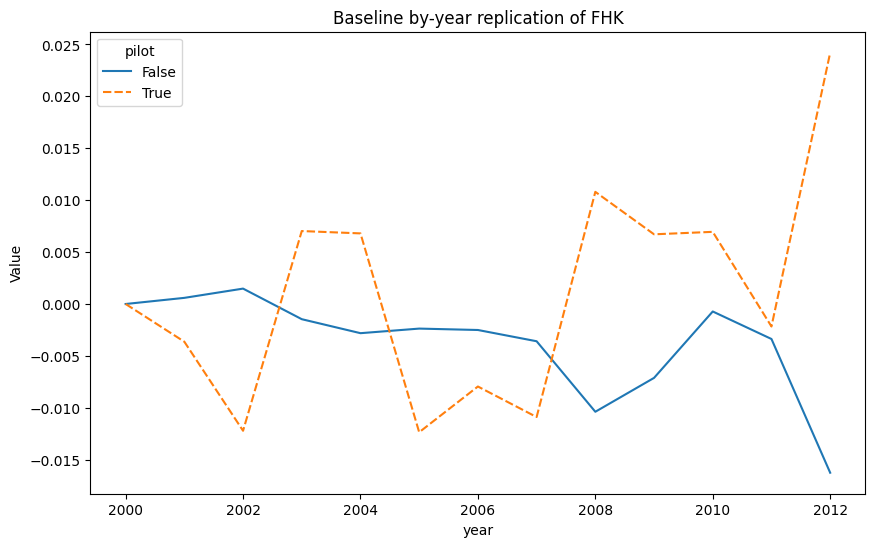

In [35]:
# 根据pilot分组,绘制折线图
plt.figure(figsize=(10, 6))
sns.lineplot(data=coef_df, x='year', y='value', hue='pilot', style='pilot')

plt.xlabel('year')
plt.ylabel('Value')
plt.title('Baseline by-year replication of FHK')
plt.show()

# 19.7 Statistical inference

在FHK的研究样本中有数千家公司，但年份相对较少，因此按年份（或公司和年份）进行标准误聚类可能会导致标准误估计出现问题，一种解决方式是采用异方差稳健标准误（heteroskedasticity-robust standard errors）。

然而假设处理的随机分配允许我们采用另一种统计推断方法——随机化推断（Randomization Inference），该方法基于随机化的理念来检验因果关系或统计显著性，而与样本中数据的聚类形式无关。如果SEC选择SHO试点公司是完全随机的，那么无论试点公司如何分配，最后的结果都会是相同的。这意味着处理的分配方式不会对结果产生影响，因此我们可以抽取其他可能分配的随机样本，用随机样本的检验统计量的经验分布作为精确分布的近似值。

In [36]:
# 定义回归参数获取函数
def get_coef_rand(i):
    shuffled_pilot = sho_accruals['pilot'].sample(frac=1).reset_index(drop=True) # 对pilot列随机打乱
    reg_data_alt = sho_accruals.drop(columns='pilot').assign(pilot=shuffled_pilot)
    reg_data_alt['pilotXduring'] = reg_data_alt['pilot'] * reg_data_alt['during']
    reg_data_alt['pilotXpost'] = reg_data_alt['pilot'] * reg_data_alt['post']
    model_RI = lm.PanelOLS.from_formula(
    formula = ("da_adj ~ pilotXduring + pilotXpost + log_at + mtob + roa + leverage + EntityEffects + TimeEffects"), # 加入公司和年度固定效应
    data = reg_data_alt.set_index(["gvkey", "fyear"]),).fit(cov_type="clustered", cluster_entity=True, cluster_time=True) # 对标准误进行聚类
    coef_RI = model_RI.params.to_dict()
    coef_RI['iteration'] = i
    return coef_RI

iterations = 1000  # 迭代次数
rand_results = pd.DataFrame([get_coef_rand(i) for i in range(1, iterations + 1)])
rand_results

d:\python\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


d:\python\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
d:\python\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
d:\python\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
d:\python\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
d:\python\Lib\site-packages\linearmodels\panel\model.py:1214: MissingVal

,pilotXduring,pilotXpost,log_at,mtob,roa,leverage,iteration
0,-0.003177,0.001782,-0.014240,-0.000541,0.130508,-0.033583,1
1,-0.002008,0.003676,-0.014242,-0.000544,0.130573,-0.033598,2
2,0.002554,0.007950,-0.014191,-0.000536,0.130503,-0.033501,3
3,0.000884,-0.005168,-0.014234,-0.000539,0.130633,-0.033477,4
4,0.000493,-0.000810,-0.014261,-0.000540,0.130594,-0.033564,5
...,...,...,...,...,...,...,...
995,-0.001656,0.007688,-0.014278,-0.000545,0.130517,-0.033615,996
996,-0.002864,-0.004171,-0.014247,-0.000539,0.130655,-0.033540,997
997,-0.000895,-0.001475,-0.014263,-0.000540,0.130582,-0.033569,998
998,-0.001029,-0.002139,-0.014249,-0.000540,0.130600,-0.033602,999


In [37]:
# 计算经验分布下回归参数的标准差,作为统计量的近似值
std_error = np.std(rand_results)
std_error

d:\python\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


pilotXduring      0.003681
pilotXpost        0.004479
log_at            0.000025
mtob              0.000003
roa               0.000112
leverage          0.000058
iteration       288.674990
dtype: float64